# Assignment 2 - Machine Learning Project
### Project 1: Classify Images of Colon Cancer
### Group No. 3: Sheikh Abdul Munim (s4076159), Liya Benoy (s4027344)

___

In [ ]:
#importing required libraries
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
#checking how many GPUs are available
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

In [2]:
#setting random seed
seed = 42 
random.seed(seed)

#setting seed for NumPy
np.random.seed(seed)

#setting seed for TensorFlow
tf.random.set_seed(seed)

#setting seed for full reproducibility (slower but stricter)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
#importing the data labels (main dataset)
labels_main = pd.read_csv('Image_classification_data\data_labels_mainData.csv')
print("labels_main columns:")
labels_main.head()

labels_main columns:


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [4]:
#importing the data labels (extra dataset)
labels_extra = pd.read_csv('Image_classification_data\data_labels_extraData.csv')
print("\nlabels_extra columns:")
labels_extra.head()


labels_extra columns:


,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


In [5]:
#navigating to folder containing colon cell histopathology images
image_folder = 'Image_classification_data\patch_images'
images = os.listdir(image_folder)
print(f"Total Numer of Images: {len(images)}")

Total Numer of Images: 20280


In [6]:
#checking if there are extra images in images folder that are not given in data labels
images_set = set(images)
csv_images_set = set(labels_main['ImageName'].astype(str))  #no '.png' added
print("Images in labels_main but missing from patch_images folder:", csv_images_set - images_set)
print("Images in patch_images folder but missing from labels_main:", images_set - csv_images_set)
#use only images that are listed in the CSV file
images_filtered = [img for img in images if img in csv_images_set]

Images in labels_main but missing from patch_images folder: set()
Images in patch_images folder but missing from labels_main: {'10974.png', '2894.png', '20441.png', '2212.png', '19586.png', '20454.png', '2589.png', '12744.png', '21264.png', '19250.png', '10565.png', '9761.png', '11632.png', '20685.png', '5861.png', '2294.png', '6082.png', '2935.png', '19198.png', '6173.png', '14860.png', '9530.png', '14619.png', '21972.png', '6158.png', '7041.png', '1640.png', '2505.png', '6049.png', '10628.png', '15336.png', '12558.png', '13086.png', '2642.png', '10390.png', '2018.png', '5286.png', '14174.png', '19342.png', '2692.png', '9524.png', '22000.png', '15934.png', '19766.png', '6706.png', '12601.png', '7203.png', '15932.png', '15393.png', '15898.png', '9743.png', '16319.png', '22154.png', '21920.png', '2412.png', '17671.png', '5095.png', '21765.png', '10634.png', '11508.png', '10800.png', '5945.png', '5820.png', '20910.png', '9545.png', '9525.png', '9792.png', '10319.png', '19107.png', '15012

In [7]:
#defining function to load images
def load_images(image_folder, image_list):
    """Returns a dictionary mapping image names to PIL image objects."""
    images = {}
    for img_name in image_list:
        img_path = os.path.join(image_folder, img_name)
        try:
            with Image.open(img_path) as img:
                images[img_name] = img.copy()  # Copy to keep it after closing
        except Exception as e:
            print(f"Error loading {img_name}: {e}")
    return images
#loading the images
image_objects = load_images(image_folder, labels_main['ImageName'])
#adding a new column 'Image' to labels_main
labels_main['Image'] = labels_main['ImageName'].map(image_objects)
labels_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,Image
0,22405,1,22405.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
1,22406,1,22406.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
2,22407,1,22407.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
3,22408,1,22408.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
4,22409,1,22409.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...


___
## I. Exploratory Data Analysis (EDA)

In [8]:
#dimensions of data frame
labels_main.shape

(9896, 7)

In [9]:
#data types of columns
labels_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
 6   Image         9896 non-null   object
dtypes: int64(4), object(3)
memory usage: 541.3+ KB


In [10]:
#mapping 'cellType' to 'cellTypeName', ensuring mappings are consistent
unique_mappings = labels_main[['cellType', 'cellTypeName']].drop_duplicates()
unique_mappings

,cellType,cellTypeName
0,0,fibroblast
11,1,inflammatory
17,3,others
449,2,epithelial


In [11]:
#getting the number of unique values in each column
#keeping only columns where all values are hashable (leaving out Image)
hashable_cols = [col for col in labels_main.columns if labels_main[col].map(lambda x: isinstance(x, (int, float, str, bool, type(None)))).all()]
#calculatting unique counts
unique_counts = labels_main[hashable_cols].nunique().sort_values(ascending=False)
print("Number of Unique Values per Column:")
print(unique_counts)

Number of Unique Values per Column:
InstanceID      9896
ImageName       9896
patientID         60
cellTypeName       4
cellType           4
isCancerous        2
dtype: int64


In [12]:
#displaying unique values and value counts for categorical variables found in last code chunk
categorical_cols = ['patientID', 'cellTypeName', 'cellType', 'isCancerous']
for col in categorical_cols:
    print(f"\nColumn: {col}")
    unique_vals = labels_main[col].nunique()
    print(f"Number of unique values: {unique_vals}")
    #showing only top 10 most common values for readability
    print("Unique Value Counts:")
    print(labels_main[col].value_counts().to_string())


Column: patientID
Number of unique values: 60
Unique Value Counts:
patientID
54    389
29    355
9     348
8     332
20    325
18    320
17    310
10    302
51    286
55    263
23    254
7     253
41    250
21    224
40    209
14    207
6     198
50    195
24    192
49    187
13    180
25    180
52    178
5     169
33    163
58    161
19    158
26    157
22    152
57    149
48    147
43    137
31    137
42    136
3     136
47    133
53    132
12    130
36    128
4     127
15    125
44    121
46    120
59    115
60    115
16    111
30    110
39    105
32     99
56     92
38     84
45     74
37     71
11     56
2      33
1      19
27     17
28     15
34     14
35     11

Column: cellTypeName
Number of unique values: 4
Unique Value Counts:
cellTypeName
epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386

Column: cellType
Number of unique values: 4
Unique Value Counts:
cellType
2    4079
1    2543
0    1888
3    1386

Column: isCancerous
Number of unique va

In [13]:
#evaluation of numerical features within data set
labels_main.describe()

,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


In [14]:
#finding total number of images
images = os.listdir(image_folder)
print(f"Total Number of Images: {len(images)}")
#checking if there are extra images in images folder that are not given in data labels
images_set = set(images)
csv_images_set = set(labels_main['ImageName'].astype(str))  #no '.png' added
print("Number of Images in labels_main but missing from patch_images folder:", len(csv_images_set - images_set))
print("Number of Images in patch_images folder but missing from labels_main:", len(images_set - csv_images_set))
#use only images that are listed in the CSV file
images_filtered = [img for img in images if img in csv_images_set]

Total Number of Images: 20280
Number of Images in labels_main but missing from patch_images folder: 0
Number of Images in patch_images folder but missing from labels_main: 10384


In [15]:
#grouping by 'cellTypeName' and 'isCancerous', then counting the entries
cell_type_counts = labels_main.groupby(['cellTypeName', 'isCancerous']).size().unstack(fill_value=0)
#renamining the columns for clarity
cell_type_counts.columns = ['Non-Cancerous', 'Cancerous']
cell_type_counts

,Non-Cancerous,Cancerous
cellTypeName,,
epithelial,0,4079
fibroblast,1888,0
inflammatory,2543,0
others,1386,0


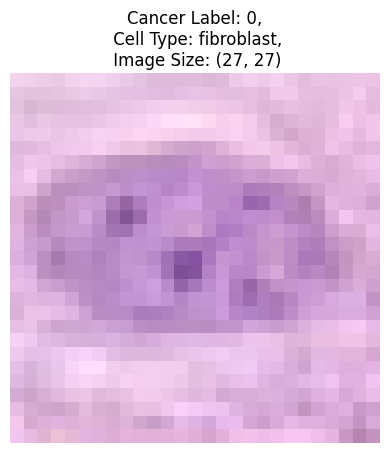

In [16]:
#fetching a single sample (e.g., for index 0)
index = 0
sample = labels_main.iloc[index]
#extracting the image, cancer label, and cell type
img = sample['Image']  # This must be a PIL Image object
cancer_label = sample['isCancerous']
cell_type = sample['cellTypeName']
#displaying the image
if img:
    plt.imshow(img)
    plt.title(f"Cancer Label: {cancer_label},\n Cell Type: {cell_type},\n Image Size: {img.size}")
    plt.axis('off')  #hiding axes
    plt.show()
else:
    print("Error: Image not found.")

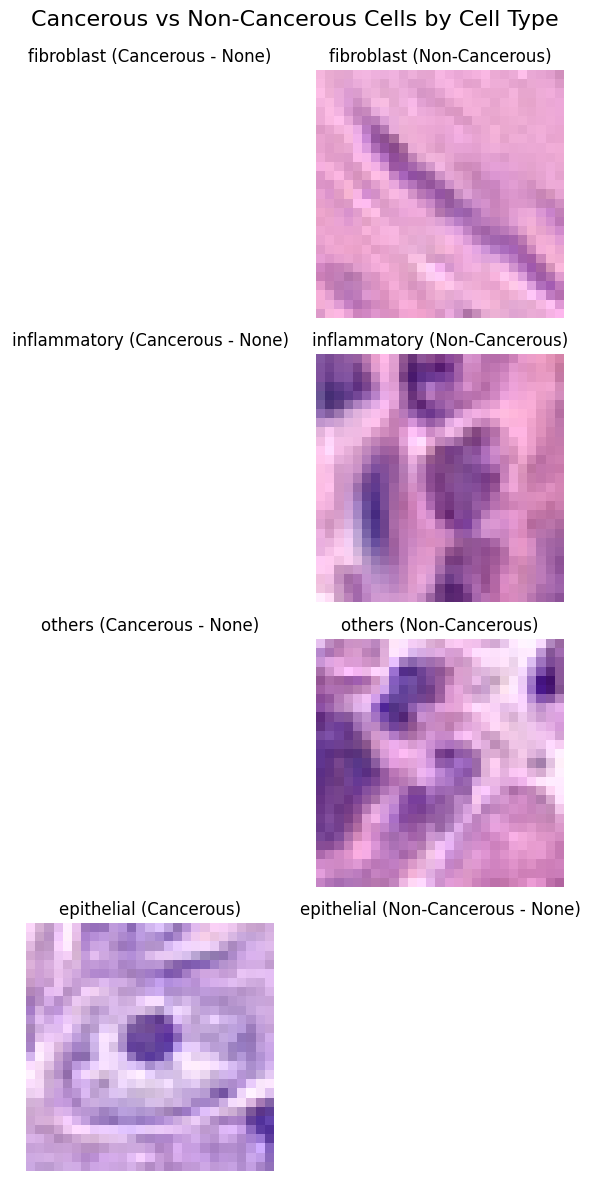

In [17]:
#getting unique cell types
cell_types = labels_main['cellTypeName'].dropna().unique()
#preparing the figure
fig, axes = plt.subplots(len(cell_types), 2, figsize=(6, 3 * len(cell_types)))
#ensure axes is 2D
if len(cell_types) == 1:
    axes = np.expand_dims(axes, axis=0)
#filtering cancerous and non-cancerous data 
for i, cell_type in enumerate(cell_types):
    cancerous_df = labels_main[(labels_main['cellTypeName'] == cell_type) & 
                               (labels_main['isCancerous'] == 1)]
    non_cancerous_df = labels_main[(labels_main['cellTypeName'] == cell_type) & 
                                   (labels_main['isCancerous'] == 0)]
    #plotting cancerous image for cell type
    if not cancerous_df.empty:
        img = cancerous_df.sample(1).iloc[0]['Image']
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"{cell_type} (Cancerous)")
    else:
        axes[i, 0].set_title(f"{cell_type} (Cancerous - None)")
    axes[i, 0].axis('off')
    #plotting non-cancerous image for cell type
    if not non_cancerous_df.empty:
        img = non_cancerous_df.sample(1).iloc[0]['Image']
        axes[i, 1].imshow(img)
        axes[i, 1].set_title(f"{cell_type} (Non-Cancerous)")
    else:
        axes[i, 1].set_title(f"{cell_type} (Non-Cancerous - None)")
    axes[i, 1].axis('off')
#plotting comparison images
plt.suptitle('Cancerous vs Non-Cancerous Cells by Cell Type', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

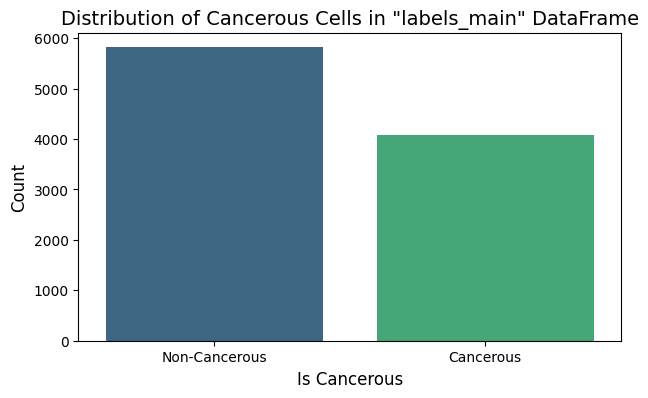

In [18]:
# Plotting the distribution of the 'isCancerous' label
plt.figure(figsize=(7, 4))
sns.countplot(data=labels_main, x='isCancerous', hue="isCancerous", palette='viridis', legend=False)
# Adding titles and labels
plt.title('Distribution of Cancerous Cells in "labels_main" DataFrame', fontsize=14)
plt.xlabel('Is Cancerous', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Non-Cancerous', 'Cancerous'])  # Adjust according to your label values
# Show the plot
plt.show()

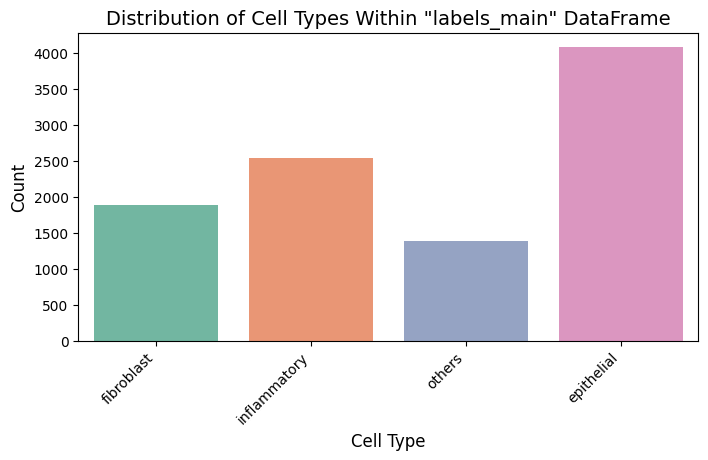

In [19]:
#plotting the distribution of the 'cellTypeName' label (consistent with 'cellType')
plt.figure(figsize=(8, 4))
sns.countplot(data=labels_main, x='cellTypeName', hue='cellTypeName', palette='Set2', legend=False)
#adding titles and labels
plt.title('Distribution of Cell Types Within "labels_main" DataFrame', fontsize=14)
plt.xlabel('Cell Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.show()

In [20]:
#checking for missing values in the entire DataFrame
missing_values = labels_main.isnull().sum()
#displaying the columns with missing values
print("Missing values in each column:")
print(missing_values)
#optionally, you can filter columns with missing values only
missing_columns = missing_values[missing_values > 0]
print("\nColumns with missing values:")
print(missing_columns)

Missing values in each column:
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
Image           0
dtype: int64

Columns with missing values:
Series([], dtype: int64)


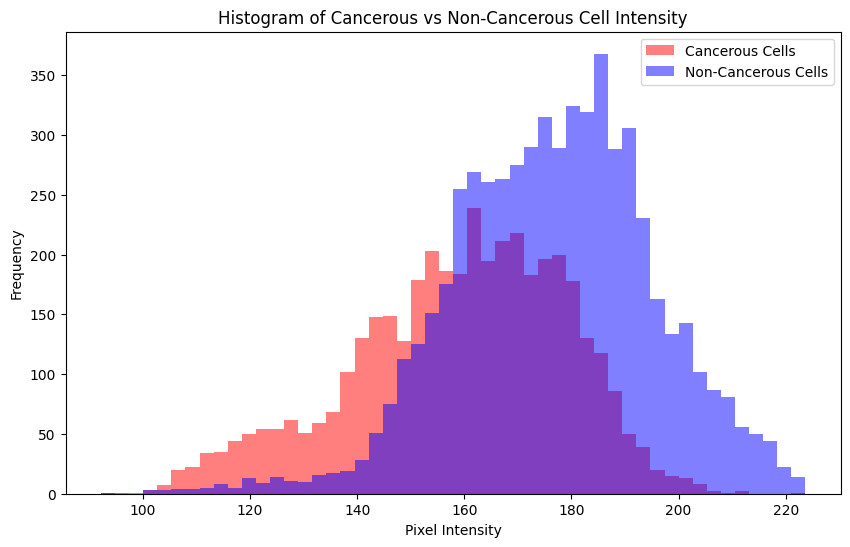

In [21]:
#defining function to calculate pixel intensity from an 'Image' object
def calculate_pixel_intensity(image_obj):
    #converting image to grayscale
    img_gray = image_obj.convert('L')  #'L' mode is for grayscale images
    #getting the pixel values as a numpy array
    pixel_values = np.array(img_gray)
    #calculating the average pixel intensity
    avg_intensity = pixel_values.mean()
    return avg_intensity

#filtering cancerous and non-cancerous cells from the DataFrame
cancerous_cells = labels_main[labels_main['isCancerous'] == 1].copy()
noncancerous_cells = labels_main[labels_main['isCancerous'] == 0].copy()
#applying the pixel intensity calculation function to each image in the 'Image' column
cancerous_cells.loc[:, 'pixel_intensity'] = cancerous_cells['Image'].apply(calculate_pixel_intensity)
noncancerous_cells.loc[:, 'pixel_intensity'] = noncancerous_cells['Image'].apply(calculate_pixel_intensity)

#extracting the pixel intensities as numpy arrays
cancerous_intensity = cancerous_cells['pixel_intensity'].values
noncancerous_intensity = noncancerous_cells['pixel_intensity'].values
#ensuring they are numpy arrays of floats for histogram calculation
cancerous_intensity = np.array(cancerous_intensity, dtype=float)
noncancerous_intensity = np.array(noncancerous_intensity, dtype=float)

#computing histograms
counts_cancer, bins = np.histogram(cancerous_intensity, bins=50)
counts_non_cancer, _ = np.histogram(noncancerous_intensity, bins=bins)

#plotting histograms
plt.figure(figsize=(10, 6))
plt.hist(cancerous_intensity, bins=bins, alpha=0.5, color='red', label='Cancerous Cells')
plt.hist(noncancerous_intensity, bins=bins, alpha=0.5, color='blue', label='Non-Cancerous Cells')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histogram of Cancerous vs Non-Cancerous Cell Intensity')
plt.show()

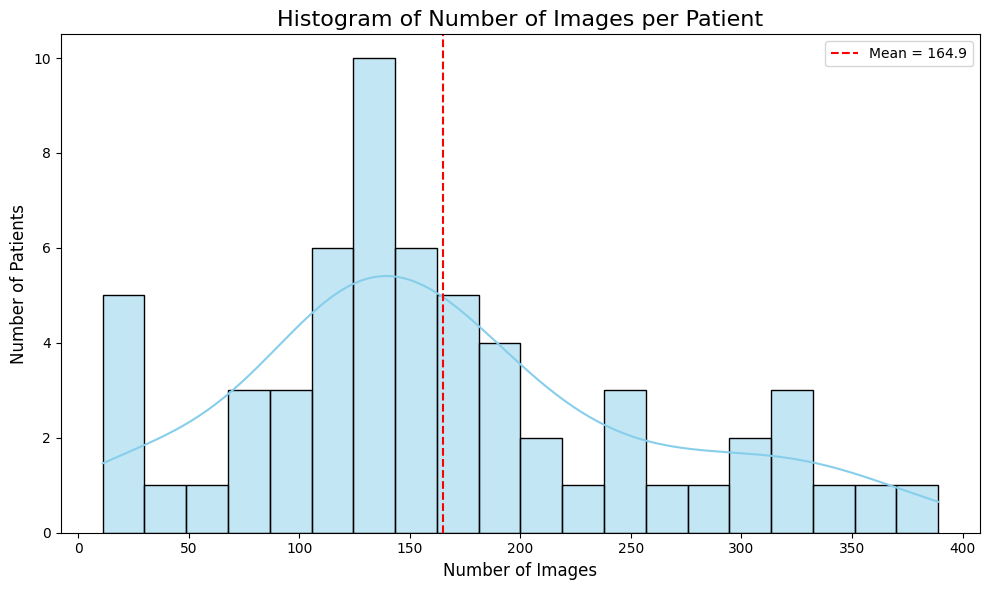

In [22]:
#counting the number of images per 'patientID'
patient_distribution = labels_main['patientID'].value_counts()
#plotting histogram
plt.figure(figsize=(10, 6))
sns.histplot(patient_distribution, bins=20, kde=True, color='skyblue')
#plotting mean line
mean_val = patient_distribution.mean()
plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean = {mean_val:.1f}')
plt.title('Histogram of Number of Images per Patient', fontsize=16)
plt.xlabel('Number of Images', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12) #number of patients that fall within each range
plt.legend()
plt.tight_layout()
plt.show()

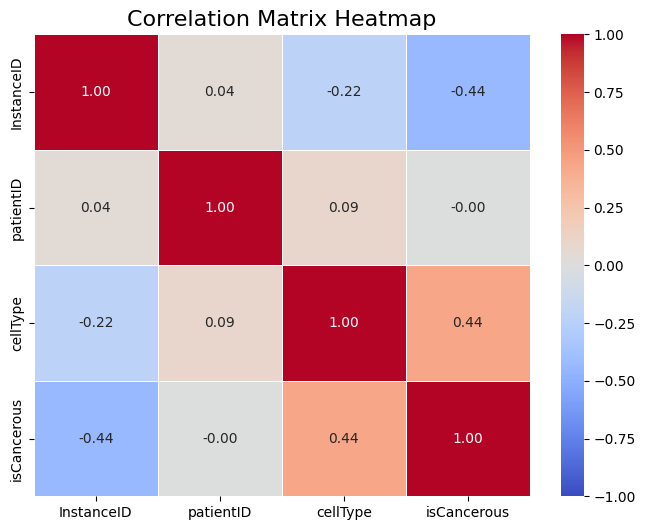

In [23]:
#selecting only numerical features from DataFrame
numerical_features = labels_main.select_dtypes(include=['float64', 'int64'])
#computing and plotting correlation matrix
corr_matrix = numerical_features.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.show()

### *EDA Observations of `labels_main` DataFrame*

- **Dimensions of Dataset**: `labels_main` contains 9,896 rows and 7 columns, a moderately-sized dataset on colon cell histopathologies that may require memory management when training a model.

- **Revealing Data Types and Unique Value Counts**: 

    - Each `InstanceID` appears once so there are 9,896 unique instances of cell histopathologies. --> `int64` data type indicates all values are integers, representing unique instance ID given to each histopathology.
    - `patientID` has 60 unique values, with patient 54 appearing 389 times, indicating that multiple colon cell histopathologies were taken from the same patient, and some more than others. --> `int64` indicates all values are integers, representing unique ID given to each patient. 
    - `ImageName` have string values like `22405.pg` occurring once within `labels_main`. --> `object` data type indicates string values, representing unique image file names.

    - **Target Variables**
    - `cellTypeName` has 4 unique string values indicating a categorical variable = `epithelial`, `inflammatory`, `fibroblast`, `others`; `epithelial` appears twice as much as the next most frequently occuring category, showing that there is a significant class imbalance within this column. --> `object` data type as categories appear as strings (name of colon cell type).
    - `cellType` is the numerical representation of `cellTypeName`, ranging from 0 to 3, the inclusion of this feature is beneficial for model training because `cellTypeName` will not have to be converted to a numerical representation. Mapping `cellType` to `cellTypeName` demonstrates numerical representations are consistent with the text representation, where 0 == fibroblast, 1 == inflammatory, 2 == others, 3 = epithelial. --> `int64` data type.
    - `isCancerous` has two unique binary values, 0 (non-cancerous, 5817 instances) and 1 (cancerous, 4079 instances), with more values for non-cancerous colon cells, indicating a class imbalance. --> `int64` data type indicates that presence of cancer is represented by binary classification labels 0 and 1.

- **Evaluating Numerical Features**
    - `InstanceID` is wide-ranging from 1 to 22444, indicating missing IDs, this indicated that this data is not sequential, just a unique identifier for each colon cell histopathology (most likely not useful for modelling).
    - There are multiple samples given per `patientID`, some more than others, indicated by the mean = 29.8 and standard deviation = 17.5, indicating a moderately evenly distribution. Patient-level stratification may be required in model training to avoid data leakage.
    - `cellType`
    - Observing a slight class imbalance within the `isCancerous` binary variable has mean = 0.41, indicating that there are are higher number of non-cancerous instances than cancerous instances. This requires certain resampling techniques in data pre-processing to address the class imabalance.

- **Image Discrepancy**: all image names given within labels_main exist within the `patch_images` folder, but there exists a significant number of extra images (10,384) within the folder, which may need to be filtered out to avoid any errors as they can not be used in supervised model training. These extra images may be linked to the `lables_extra` data set. 

- **Target Variable Analysis**
    - When mapping the number of entries per `cellTypeName` to its `isCancerous` label, cancerous colon cells are only associated with the `epithelial` cell, while all other cell types are non-cancerous, indicating that `cellTypeName` is a significant predictor for detecting cancer in a colon cell. This also indicates that the data set is heavily biased to certain colon cell types. But including `cellTypeName` in model training might cause data leakage, as models can then trivially predict `isCancerous` label. Both target variables may need to be excluded from the other's model training.

- **Inspection of Sample Image**
    - The randomly selected image has 27x27 pixels, indicating that images in the dataset may be very small and have low resolution (as shown by the blurry image). There may need to be resizing in data pre-processing to ensure the model is able to process the images.
    - When observing the randomly selected image for each `cellTypeName` and `isCancerous` label, again you can observe the class imbalance as `fibroblast`, `inflammatory`, and `others` histopathologies appears in non-cancerous sample images, and `epithelial` only appears in cancerous ones. This reveals the imbalance in the data.
    - When observing the differences between cancerous and non-cancerous cells, non-cancerous cells appear to have less dark matter while the cancerous sample appears to have mostly dark matter. But visually, it is difficult to really differentiate as we do not have the opposing sample for each `cellTypeName`, making it harder to distinguish visually. 
    - This reinforces the need to exclude or specifically handle `cellTypeName` when predicting for `isCancerous` as the chance of overfitting and data leakage is high, as `cellTypeName` and `isCancerous` seem to be perfectly correlated in this dataset.

- **Distribution of `isCancerous`**: the data set is slightly skewed towards non-cancerous samples, and required resampling techniques to avoid bias and increase accuracy in model training. Once agian, it reveals the class imbalance.

- **Distribution of `cellTypeName`**: the `epithelial` colon cell histopathologies dominate the other cell types, once again revealing risk of overfitting and data leakage, due to high class imbalance.

- **Missing Values**: All columns in `labels_main` have no missing values, so there is no need for any missing value handling in data pre-processing.

- **Pixel Intensity Distribution**: 
    - The pixel intensity distribution histograms of the colon cell histopathologies for `isCancerous` == 1 vs. `isCancerous` == 0, both distributions are roughly bell-shaped, indicating that both are normally distributed. 
    - Cancerous cells tend to have lower pixel intensities (peaking around 160), while non-cancerous cells have relatively higher intensities (peaking around 180). 
    - Despite there being some overlap of intensities between cancerous vs. non-cancerous, the cancerous cells occur less frequently at these higher intensities.
    - This clear distinction in pixel intensity could be a predictive factor for the classification model to differentiate between cancerous and non-cancerous histopathologies.

- **Distribution of Images Per Patient**:
    - Histogram indicates that patient distribution is not normally distributed, no clear bell-shape, but it does indicate a slight right skew.
    - Reinforces the need for stratified sampling, some patients have contributed more colon cell histopathologies than others (>250), but these patients are less frequently occuring.
    - Average number of images per patient is 164.9, but most patients fall under this line, indicating a heavily imbalanced distribution.

- **Correlation Matrix Heatmap of Numerical Features**:
    - The heatmap indicates that `cellType` has a moderate positive correlation (0.44) with `isCancerous`, which means that it could be a significant predictor for `isCancerous` label in the classification model. But as discussed before, it may be incur too much bias and trivial predictions due to class imbalance. 
    - `InstanceID` being an identifier may mean it is not very meaningful for prediction (despite having -0.44 moderate negative correlation with `isCancerous`).
    - `patientID` also being an identifier has near-zero correlation with all features, again, not meaningful for prediction.

### *Class Imbalance Identification*

- **Class Imbalance in `cellTypeName`/`cellType`**: between the 4 classes of colon cell types represented in the histopathologies: fibroblast (0), inflammatory (1), others (2), and epithelial (3), there is significant class imbalance as epithelial appears twice as more as the next most frequently occuring cell type class. Typically this would indicate need for resampling during data pre-processing, but since it is observed to have perfect correlation with `isCancerous` due to huge gaps in data, `cellTypeName` and `cellType` may need to be excluded as a feature in the classification model for `isCancerous` (and vice versa) to avoid data leakage, overfitting, and trivial predictions.

- **Binary Imbalance in `isCancerous`**: there is nearly 1,800 more samples for non-cancerous (5,817) colon cell histopathologies than cancerous ones (4,079), though is not a significant imbalance, this requires use of resampling techniques or class weighting in data pre-processing. 

- **Distributional Imbalance in `patientID`**: certain patients have disproportionately contributed more colon cell histopathology samples than others, revealing an imbalanced representation of patients, this could lead overfitting as models learn patient-specific patterns and not general patterns. Patient-level stratification will be required when splitting the data in data pre-processing to prevent data leakage.

___
## II. Data Pre-processing

### *Rationale for Data Pre-processing Methods*

- **Image Resizing**: 
    - All histopathology images were resized to 27x27 pixels to standardize input image dimensions for the classification models built for Task 1 and 2. 
    - As the chosen architecture is Convolutional Neural Networks (CNN), resizing images to smaller dimensions helps reduce computational load and memory usage, hence improving the performance of the classification model by facilitating faster and more efficient training. 
    - Resizing to 27x27 allows these benefits while preserving the necessary spatial features within the images for the model to make accurate classification predictions. 

- **Image Normalization**: 
    - All pixel values are normalized to the range [0, 1] by dividing the values by 255. 
    - During EDA, there was significant variability in the pixel intensity distribution accross images, especially between `isCancerous` labels, so by normalizing the pixel values, the input scales are standardized across images. 
    - This helps ensure optimal performance of the CNN model by ensuring numerical stability, efficient training, faster model convergence, focus on meaningful patterns and hence improve generalization, and reduce overfitting.

- **Label Preparation**: 
    - For Task 1, which involves the binary classification model for `isCancerous` label, the `labels_main` and `labels_extra` dataframes were merged to increase the number of training samples, to include as many diverse samples of cancerous and non-cancerous images as possible to help improve the generalization power and prevent overfitting of the classification model.
    - For Task 2, which involves the multi-class classification model for `cellType`, only `labels_main` dataframe is used, as `labels_extra` lacks `cellType` or `cellTypeName` columns as a whole. 

- **One-Hot Encoding**:
    - Task 1's target feature, `isCancerous`, is already encoded as it in binary form, integers '0' or '1', thus requires no further data pre-processing.
    - Task 2's target feature, `cellType`, as a categorical feature requires one-hot encoding to convert the current integer labels to binary vectors. As Task 2 is a multi-class classification model that expects target features to be in one-hot encoded format, this helps each class be treated as categorical feature, separate and equidistant, and not as ordinal data.

- **Error Handling**: to ensure corrupt image files are blocked from entering the training pipeline for the classification models and causing errors in generalization, `try-except` blocks are used to skip such files and log the errors.

### *Handling Class Imbalance*

**TASK 1**
- Class imbalance in `isCancerous` was discovered during EDA where non-cancerous samples (~60%) are more frequent in the data set than cancerous samples (~40%). 
- Hence, the `labels_main` dataset was merged with `labels_extra`, only for the Task 1 binary classification model, to increase the number of cancerous samples amd restore balance.

**TASK 2**
- T


In [ ]:
"""    
The following code loads the images, resizes them to 27x27 pixels, normalizes the pixel values, and prepares the labels for CNN training.
The code also combines the labels from the main and extra detasets, however if you do not want to use the extra dataset, you can comment out the lines that load and concate the extra dataset.
The code also handles exceptions while loading images and prints the final shapes of the image dataset and labels.

"""
#lists to store the data
X_task1 = []
y_isCancerous = []
X_task2 = []
y_cellType = []

#combining only the isCancerous labels for Task 1
labels_task1 = pd.concat([labels_main, labels_extra], ignore_index=True)
#using only main labels for Task 2 (cellType)
labels_task2 = labels_main.copy()

#building separate dictionaries for fast lookup
labels_dict_task1 = labels_task1.set_index('ImageName').to_dict('index')
labels_dict_task2 = labels_task2.set_index('ImageName').to_dict('index')

#preparing list of all image names to be loaded (main + extra)
all_image_names = set(labels_task1['ImageName'])  # includes both main and extra

#loading and preprocess images
for img_name in all_image_names:
    try:
        img_path = os.path.join(image_folder, img_name)
        img = Image.open(img_path)
        img = img.resize((27, 27))  #ensuring all images are 27x27
        img_array = np.array(img) / 255.0  #normalize pixel values (0-1)
        #adding to Task 1 (isCancerous)
        if img_name in labels_dict_task1:
            X_task1.append(img_array)
            y_isCancerous.append(labels_dict_task1[img_name]['isCancerous'])
        #adding to Task 2 (cellType) only if it has a cellType label
        if img_name in labels_dict_task2:
            X_task2.append(img_array)
            y_cellType.append(labels_dict_task2[img_name]['cellType'])  
    except Exception as e:
        print(f"Error processing {img_name}: {e}")

#converting to numpy arrays
X_task1 = np.array(X_task1)
y_isCancerous = np.array(y_isCancerous)
X_task2 = np.array(X_task2)
y_cellType = np.array(y_cellType)

#printing shapes of resulting target and predictor features
print(f"Task 1 (isCancerous) - X shape: {X_task1.shape}, y shape: {y_isCancerous.shape}")
print(f"Task 2 (cellType) - X shape: {X_task2.shape}, y shape: {y_cellType.shape}")

Task 1 (isCancerous) - X shape: (20280, 27, 27, 3), y shape: (20280,)
Task 2 (cellType) - X shape: (9896, 27, 27, 3), y shape: (9896,)


In [ ]:
#encoding for task 1
y_isCancerous = np.array(y_isCancerous)
print(f"Task 1 (isCancerous) labels shape: {y_isCancerous}") #it is already binary so no need to encode

#encoding for task 2
le = LabelEncoder() #initialize label encoder
#integer encoding
y_cellType_encoded = le.fit_transform(y_cellType)
#one-hot encoding for multiclass classification
y_cellType_encoded = to_categorical(y_cellType_encoded)
print(f"Task 2 (cellType) labels shape: {y_cellType_encoded}")

#checking values after encoding
print(f"Cell type classes: {le.classes_}")

Task 1 (isCancerous) labels shape: [0 0 1 ... 0 0 0]
Task 2 (cellType) labels shape: [[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
Cell type classes: [0 1 2 3]


In [ ]:
#preserving encoding order for future reference

#storing the classes for later use
cell_type_classes = le.classes_

#saving this to a file for reuse
np.save("cell_type_classes.npy", cell_type_classes)
print("Cell Type Classes (Preserved):", cell_type_classes)

#load the saved classes (when needed)
loaded_classes = np.load("cell_type_classes.npy")
print("Loaded Cell Type Classes:", loaded_classes)

Cell Type Classes (Preserved): [0 1 2 3]
Loaded Cell Type Classes: [0 1 2 3]


C:\Users\Munim\AppData\Local\Temp\ipykernel_24060\1132786360.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_cellType_int, palette=colors, order=range(len(cell_type_classes)))


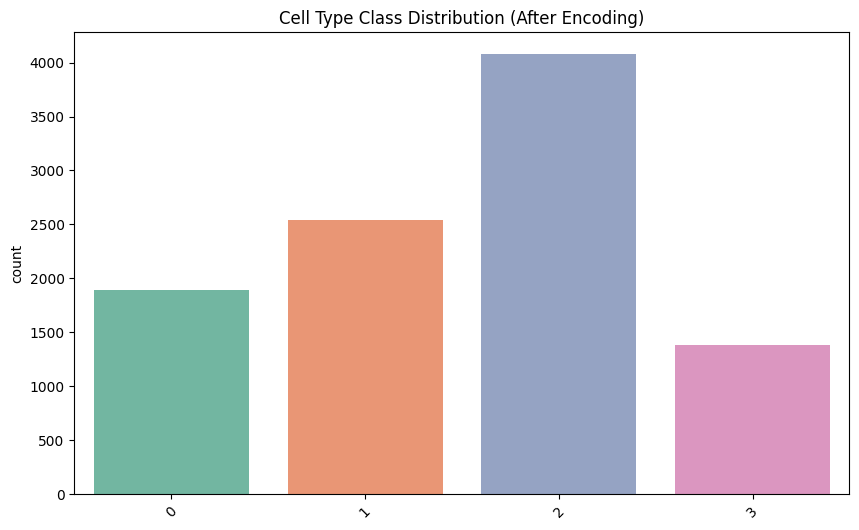

C:\Users\Munim\AppData\Local\Temp\ipykernel_24060\1132786360.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_isCancerous, palette=colors, order=[0, 1])


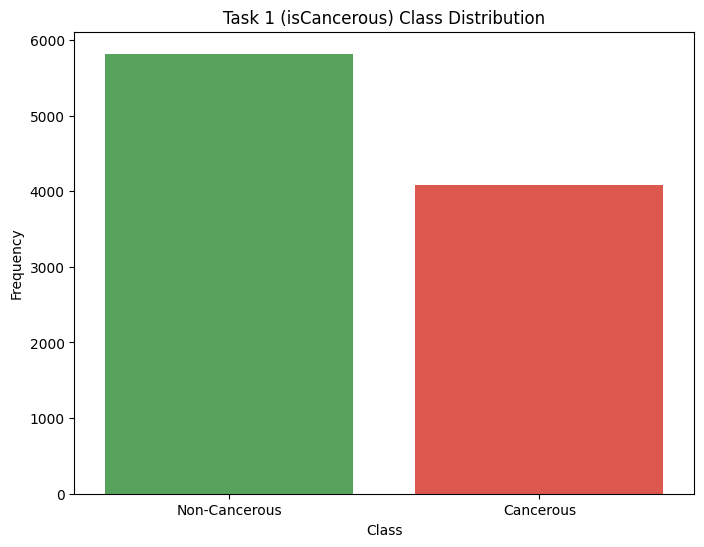

In [ ]:
#plotting the distribution after handling class imbalance for Task 1 and Task 2

#converting one-hot encoded back to integer for visualization
y_cellType_int = np.argmax(y_cellType_encoded, axis=1)

#plotting distribution for 'isCancerous'
colors = ['#4CAF50', '#F44336'] #green for non-cancerous, red for cancerous
plt.figure(figsize=(8, 6))
sns.countplot(x=y_isCancerous, palette=colors, order=[0, 1])
plt.title("Task 1 (isCancerous) Class Distribution")
plt.xticks(ticks=[0, 1], labels=["Non-Cancerous", "Cancerous"])
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

#plotting distribution for 'cellType' 
colors = sns.color_palette("Set2", len(cell_type_classes)) #defining a color palette with as many colors as unique cell types
plt.figure(figsize=(10, 6))
sns.countplot(x=y_cellType_int, palette=colors, order=range(len(cell_type_classes)))
plt.title("Cell Type Class Distribution (After Encoding)")
plt.xticks(ticks=range(len(cell_type_classes)), labels=cell_type_classes, rotation=45)
plt.show()

In [ ]:
#saving data for label mappings for later use
cell_type_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Cell Type Mapping:", cell_type_mapping)

#final check on data shapes
print(f"Final X_task1 shape: {X_task1.shape}")
print(f"Final y_isCancerous shape: {y_isCancerous.shape}")
print(f"Final X_task2 shape: {X_task2.shape}")
print(f"Final y_cellType_encoded shape: {y_cellType_encoded.shape}")

Cell Type Mapping: {0: 0, 1: 1, 2: 2, 3: 3}
Final X_task1 shape: (9896, 27, 27, 3)
Final y_isCancerous shape: (9896,)
Final X_task2 shape: (9896, 27, 27, 3)
Final y_cellType_encoded shape: (9896, 4)


### *Data Splitting Strategy*

- **Splitting by `patientID`**:

- **Train-Test Split**:

In [ ]:
"""Since it is a patient-based dataset, splitting randomly may lead to data leakages, to tacke this, we will split the data based on patient IDs.
    The training, validation, and testing sets has split ratios of 80%, 10%, and 10% respectively.
    For the splitting stratified sampling is used to ensure that the distribution of the labels is similar in all sets.
    The strafication is done based on patient IDs, so that all images from a single patient are in the same set.
"""
#extracting 'patientID' from the dataset for each task
patient_ids_task1 = [name.split('_')[0] for name in labels_task1['ImageName']]
patient_ids_task2 = [name.split('_')[0] for name in labels_task2['ImageName']]
#getting unique patient IDs
unique_patients_task1 = np.unique(patient_ids_task1)
unique_patients_task2 = np.unique(patient_ids_task2)
#printing unqiue patients per task
print(f"Unique patients in Task 1: {len(unique_patients_task1)}")
print(f"Unique patients in Task 2: {len(unique_patients_task2)}")

Unique patients in Task 1: 20280
Unique patients in Task 2: 9896
Task 1 - Train: (6372, 27, 27, 3), Val: (1586, 27, 27, 3), Test: (1938, 27, 27, 3)
Task 2 - Train: (6332, 27, 27, 3), Val: (1584, 27, 27, 3), Test: (1980, 27, 27, 3)


In [ ]:
#splitting the unique patient IDs into training and testing sets
#Task 1 (isCancerous)
train_patients_task1, test_patients_task1 = train_test_split(unique_patients_task1, test_size=0.2, random_state=42)
train_patients_task1, val_patients_task1 = train_test_split(train_patients_task1, test_size=0.2, random_state=42)
#Task 2 (cellType)
train_patients_task2, test_patients_task2 = train_test_split(unique_patients_task2, test_size=0.2, random_state=42)
train_patients_task2, val_patients_task2 = train_test_split(train_patients_task2, test_size=0.2, random_state=42)

In [ ]:
#grouping images by 'patientID'

#Task 1 (isCancerous)
X_train_task1, y_train_task1 = [], []
X_val_task1, y_val_task1 = [], []
X_test_task1, y_test_task1 = [], []

for i, img in enumerate(X_task1):
    patient_id = labels_task1.iloc[i]['ImageName'].split('_')[0]
    if patient_id in train_patients_task1:
        X_train_task1.append(img)
        y_train_task1.append(y_isCancerous[i])
    elif patient_id in val_patients_task1:
        X_val_task1.append(img)
        y_val_task1.append(y_isCancerous[i])
    elif patient_id in test_patients_task1:
        X_test_task1.append(img)
        y_test_task1.append(y_isCancerous[i])

#Task 2 (cellType)
X_train_task2, y_train_task2 = [], []
X_val_task2, y_val_task2 = [], []
X_test_task2, y_test_task2 = [], []

for i, img in enumerate(X_task2):
    patient_id = labels_task2.iloc[i]['ImageName'].split('_')[0]
    if patient_id in train_patients_task2:
        X_train_task2.append(img)
        y_train_task2.append(y_cellType_encoded[i])
    elif patient_id in val_patients_task2:
        X_val_task2.append(img)
        y_val_task2.append(y_cellType_encoded[i])
    elif patient_id in test_patients_task2:
        X_test_task2.append(img)
        y_test_task2.append(y_cellType_encoded[i])

In [ ]:
#converting all training, validation, and test sets for each task to numpy arrays
#Task 1
X_train_task1 = np.array(X_train_task1)
X_val_task1 = np.array(X_val_task1)
X_test_task1 = np.array(X_test_task1)
y_train_task1 = np.array(y_train_task1)
y_val_task1 = np.array(y_val_task1)
y_test_task1 = np.array(y_test_task1)
#Task 2
X_train_task2 = np.array(X_train_task2)
X_val_task2 = np.array(X_val_task2)
X_test_task2 = np.array(X_test_task2)
y_train_task2 = np.array(y_train_task2)
y_val_task2 = np.array(y_val_task2)
y_test_task2 = np.array(y_test_task2)

In [ ]:
#printing the final shapes of training, validation, and test sets
print(f"Task 1 - Train: {X_train_task1.shape}, Val: {X_val_task1.shape}, Test: {X_test_task1.shape}")
print(f"Task 2 - Train: {X_train_task2.shape}, Val: {X_val_task2.shape}, Test: {X_test_task2.shape}")

### *Prevention of Data Leakage*

- 

___
## III. Building Baseline Model

### *Baseline Model Selection and Justification*

- 



Baseline Model 1: CNN

In [ ]:

# Basic Feedforward Neural Network for Task 1 (isCancerous)

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense

# Simplest Baseline Model
baseline_nn_task1 = Sequential([
    Flatten(input_shape=(27, 27, 3)),  # Flatten the 3D image to 1D
    Dense(1, activation='sigmoid')     # Single neuron for binary classification
])

# Compile the model with basic settings
baseline_nn_task1.compile(
    loss='binary_crossentropy',  # Binary classification
    optimizer='sgd',             # Simple gradient descent optimizer
    metrics=['accuracy']
)

# Model summary
baseline_nn_task1.summary()



Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_17 (Flatten)        (None, 2187)              0         


                                                                 
 dense_46 (Dense)            (None, 1)                 2188      
                                                                 
Total params: 2,188
Trainable params: 2,188
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
160/160 [==============================] - 1s 7ms/step - loss: 0.3060 - accuracy: 0.8723 - val_loss: 0.3344 - val_accuracy: 0.8541
Epoch 2/30
160/160 [==============================] - 1s 6ms/step - loss: 0.3184 - accuracy: 0.8662 - val_loss: 0.3298 - val_accuracy: 0.8573
Epoch 3/30
160/160 [==============================] - 1s 6ms/step - loss: 0.3077 - accuracy: 0.8695 - val_loss: 0.4172 - val_accuracy: 0.7945
Epoch 4/30
160/160 [==============================] - 1s 6ms/step - loss: 0.3123 - accuracy: 0.8660 - val_loss: 0.5275 - val_accuracy: 0.7561
Epoch 5/30
160/160 [==============================] - 1s 6ms/step - loss: 0.3070 - accuracy: 0.8693 - val_loss: 0.3349 - val_accuracy: 0.8627
Epoch 6/30
160/160 [==============================] - 1s 7ms/step - loss: 0.3072 - accuracy: 0.8709 - val_loss: 0.3642 - val_accuracy: 0.8369
Epoch 7/30
160/160 [==============================] - 1s 6ms/step - loss: 0.3057 - accuracy: 0.8693 - val_loss: 0.3461 - val_accuracy: 0.8580
Epoch 

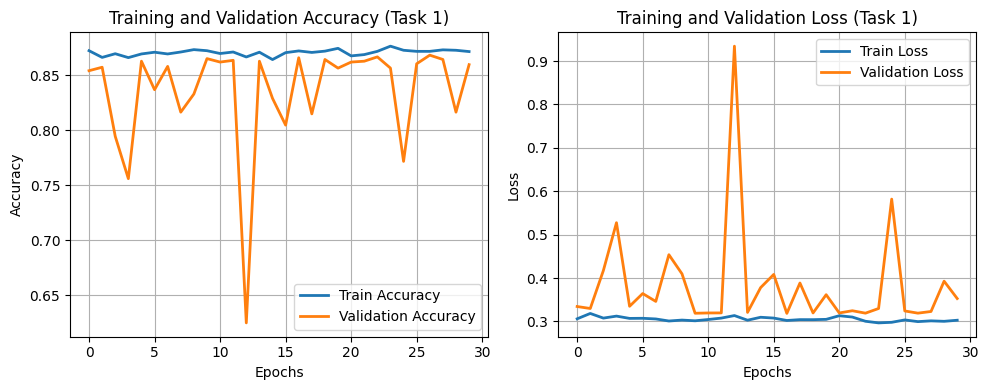

61/61 [==============================] - 0s 3ms/step

Classification Report:
               precision    recall  f1-score   support

Non-Cancerous       0.93      0.77      0.84      1112
    Cancerous       0.75      0.92      0.83       826

     accuracy                           0.83      1938
    macro avg       0.84      0.85      0.83      1938
 weighted avg       0.85      0.83      0.84      1938



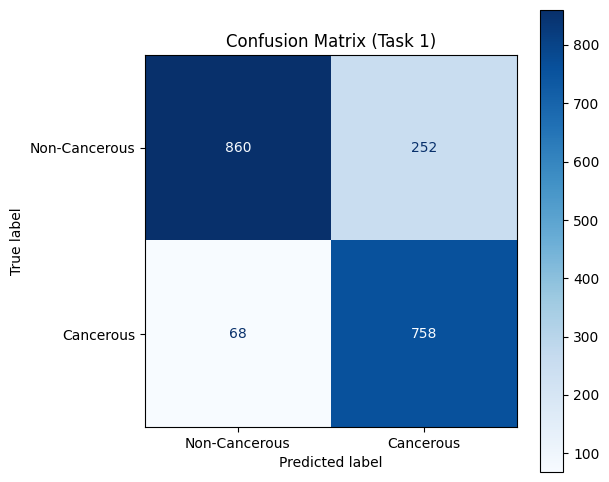

Precision: 0.7505
Recall: 0.9177
F1-Score: 0.8257
ROC-AUC Score: 0.9356
Matthews Correlation Coefficient (MCC): 0.6841


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# Train the Model
history_task1 = baseline_nn_task1.fit(
    X_train_task1, 
    y_train_task1,
    epochs=30,
    batch_size=32,
    validation_split=0.2
)

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_task1.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history_task1.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy (Task 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_task1.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_task1.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss (Task 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Get Predictions
y_pred_probs = baseline_nn_task1.predict(X_test_task1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert to binary labels

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test_task1, y_pred, target_names=['Non-Cancerous', 'Cancerous']))

# Confusion Matrix
cm = confusion_matrix(y_test_task1, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Cancerous', 'Cancerous'])
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix (Task 1)')
plt.show()

# Separate Precision, Recall, F1-Score
precision = precision_score(y_test_task1, y_pred)
recall = recall_score(y_test_task1, y_pred)
f1 = f1_score(y_test_task1, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# ROC-AUC Score
roc_auc = roc_auc_score(y_test_task1, y_pred_probs)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test_task1, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")


In [128]:
# Evaluate on Validation Set
test_loss, test_accuracy = baseline_nn_task1.evaluate(X_val_task1, y_val_task1)
print(f"Test Accuracy (Task 1 - isCancerous): {test_accuracy:.4f}")


# Final Evaluation
# test_loss, test_accuracy = baseline_cnn_task1.evaluate(X_test_task1, y_test_task1)
# print(f"Test Accuracy (Task 1 - isCancerous): {test_accuracy:.4f}")

50/50 [==============================] - 0s 4ms/step - loss: 0.3776 - accuracy: 0.8354
Test Accuracy (Task 1 - isCancerous): 0.8354


## Improving CNN Model from Baseline Task-1 (Binary Classification)

In [139]:
# Improved Binary Classification Model for Task 1 (isCancerous)

"""Input shape: 27x27x3 (for RGB images)
Output shape: 1 (binary classification)"""

#Model Architecture

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers  # for layers like Conv2D, Dense, etc.
from tensorflow.keras import optimizers  # if using custom optimizers like SGD
from tensorflow.keras import regularizers  # for L2 regularization
from tensorflow.keras import callbacks  # for EarlyStopping, ModelCheckpoint, etc.
from tensorflow.keras import preprocessing  # for image preprocessing functions

from tensorflow.keras.layers import Activation

from tensorflow.keras.optimizers import RMSprop



#Convulutional block 1

improved_cnn_task1 = Sequential()
improved_cnn_task1.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001), input_shape=(27,27,3)))
improved_cnn_task1.add(Activation('relu'))
improved_cnn_task1.add(MaxPooling2D(pool_size=(2, 2)))



#Convulutional block 2
improved_cnn_task1.add(Conv2D(64, (3, 3)))
improved_cnn_task1.add(Activation('relu'))
improved_cnn_task1.add(MaxPooling2D(pool_size=(2, 2)))

#Convulutional block 3

improved_cnn_task1.add(Conv2D(128, (3, 3)))
improved_cnn_task1.add(Activation('relu'))
# Optional: pooling after third conv
# improved_cnn_task1.add(MaxPooling2D(pool_size=(2, 2)))

# #Convulutional block 4
# improved_cnn_task1.add(Conv2D(256, (3, 3)))
# improved_cnn_task1.add(Activation('relu'))



#start multiple layers

improved_cnn_task1.add(Flatten()) # Flatten the 3d tensor to 1d
improved_cnn_task1.add(Dense(64))
improved_cnn_task1.add(Activation('relu'))
improved_cnn_task1.add(Dropout(0.5))  # Dropout layer to reduce overfitting
improved_cnn_task1.add(Dense(1))  # Output layer for binary classification
improved_cnn_task1.add(Activation('sigmoid'))  # Sigmoid activation for binary classification

# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# improved_cnn_task1.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Model summary
improved_cnn_task1.summary()


# optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)


optimizer = Adam(learning_rate=0.0001)

# optimizer = RMSprop(learning_rate=0.0005)

# optimizer = RMSprop(learning_rate=0.0001, decay=1e-6, momentum=0.9)


improved_cnn_task1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# improved_cnn_task1.compile(loss='binary_crossentropy',
#                            optimizer='sgd',
#                            metrics=['accuracy'])



## Some comments 
""" Reducing one maxpooling layer increased the accuracy of the model.
    RMSprop optimizer with learning rate of 0.0005 is not giving good results however the accuracy was good but with lots of spike in the loss graph.
    Adam optimizer with learning rate of 0.0001 is giving good results."""

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_74 (Conv2D)          (None, 25, 25, 32)        896       
                                                                 
 activation_106 (Activation)  (None, 25, 25, 32)       0         
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_75 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 activation_107 (Activation)  (None, 10, 10, 64)       0         
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                

' Reducing one maxpooling layer increased the accuracy of the model.\n    RMSprop optimizer with learning rate of 0.0005 is not giving good results however the accuracy was good but with lots of spike in the loss graph.\n    Adam optimizer with learning rate of 0.0001 is giving good results.'

In [39]:
# Improving CNN Model from Baseline 


"""Data augmentating did not improve the accuracy of the model."""

# Image data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize + augment
augment_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Validation data — only rescaling
val_gen = ImageDataGenerator(rescale=1./255)

# Create generators from array data
train_generator = augment_gen.flow(X_train_task1, y_train_task1, batch_size=32)
val_generator = val_gen.flow(X_test_task1, y_test_task1, batch_size=32)

Epoch 1/20
197/200 [============================>.] - ETA: 0s - loss: 0.6107 - accuracy: 0.6686
Epoch 1: val_loss improved from inf to 0.48144, saving model to best_model_task1.h5
200/200 [==============================] - 3s 12ms/step - loss: 0.6094 - accuracy: 0.6698 - val_loss: 0.4814 - val_accuracy: 0.8039
Epoch 2/20
195/200 [============================>.] - ETA: 0s - loss: 0.4249 - accuracy: 0.8175
Epoch 2: val_loss improved from 0.48144 to 0.35837, saving model to best_model_task1.h5
200/200 [==============================] - 2s 12ms/step - loss: 0.4241 - accuracy: 0.8181 - val_loss: 0.3584 - val_accuracy: 0.8555
Epoch 3/20
196/200 [============================>.] - ETA: 0s - loss: 0.3585 - accuracy: 0.8603
Epoch 3: val_loss improved from 0.35837 to 0.31168, saving model to best_model_task1.h5
200/200 [==============================] - 2s 12ms/step - loss: 0.3593 - accuracy: 0.8599 - val_loss: 0.3117 - val_accuracy: 0.8777
Epoch 4/20
200/200 [==============================] - ET

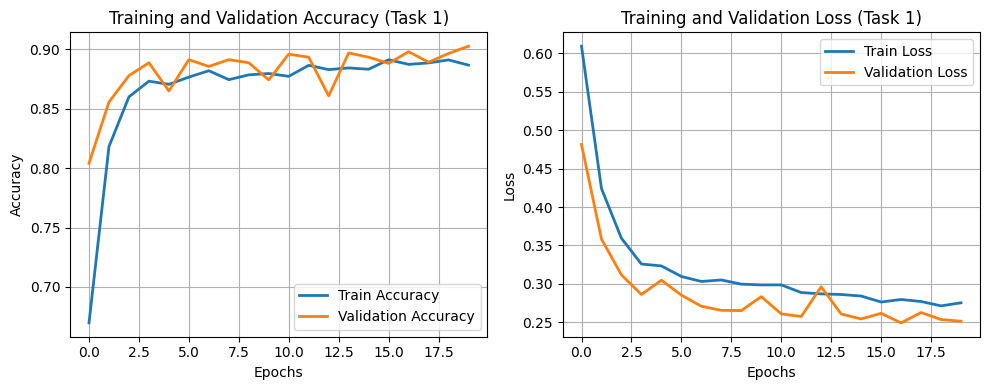

61/61 [==============================] - 0s 3ms/step

Classification Report:
               precision    recall  f1-score   support

Non-Cancerous       0.93      0.77      0.84      1112
    Cancerous       0.75      0.92      0.83       826

     accuracy                           0.83      1938
    macro avg       0.84      0.85      0.83      1938
 weighted avg       0.85      0.83      0.84      1938



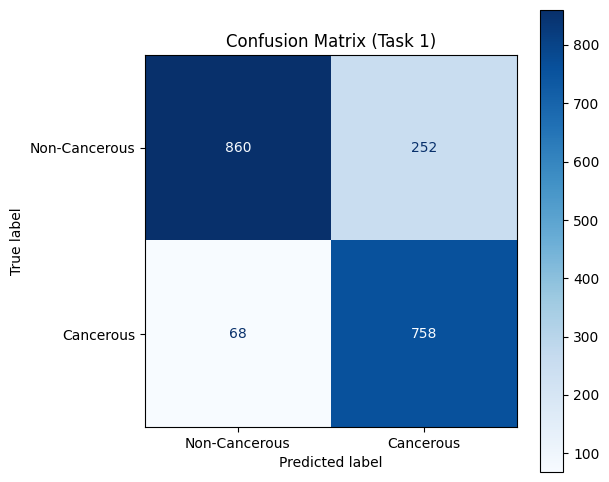

Precision: 0.7505
Recall: 0.9177
F1-Score: 0.8257
ROC-AUC Score: 0.9356
Matthews Correlation Coefficient (MCC): 0.6841


In [140]:
# history = improved_cnn_task1.fit(
#     train_generator,
#     epochs=20,
#     validation_data=val_generator,
#     steps_per_epoch=len(X_train_task1) // 32,
#     validation_steps=len(X_test_task1) // 32,
#     #callbacks=[early_stop, model_checkpoint]  # Optional: add EarlyStopping, etc.
# )


# Without augmentation

# early stopping and model checkpointing

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,  # number of epochs to wait before stopping
    restore_best_weights=True,
    verbose=1
)

# Model checkpoint to save the best model based on val_loss
model_checkpoint = ModelCheckpoint(
    filepath='best_model_task1.h5',  # you can name this whatever you like
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)




history_task1 = improved_cnn_task1.fit(
    X_train_task1,
    y_train_task1,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_task1, y_test_task1),
    callbacks=[early_stop, model_checkpoint]  # Add reduce_lr or live_plot if needed
)

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_task1.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history_task1.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy (Task 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_task1.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_task1.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss (Task 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Get Predictions
y_pred_probs = baseline_nn_task1.predict(X_test_task1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert to binary labels

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test_task1, y_pred, target_names=['Non-Cancerous', 'Cancerous']))

# Confusion Matrix
cm = confusion_matrix(y_test_task1, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Cancerous', 'Cancerous'])
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix (Task 1)')
plt.show()

# Separate Precision, Recall, F1-Score
precision = precision_score(y_test_task1, y_pred)
recall = recall_score(y_test_task1, y_pred)
f1 = f1_score(y_test_task1, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# ROC-AUC Score
roc_auc = roc_auc_score(y_test_task1, y_pred_probs)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test_task1, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")







In [41]:
# Final Evaluation
test_loss, test_accuracy = improved_cnn_task1.evaluate(X_val_task1, y_val_task1)
print(f"Test Accuracy (Task 1 - isCancerous): {test_accuracy:.4f}")

# Final Evaluation
# test_loss, test_accuracy = improved_cnn_task1.evaluate(X_test_task1, y_test_task1)
# print(f"Test Accuracy (Task 1 - isCancerous): {test_accuracy:.4f}")

50/50 [==============================] - 0s 7ms/step - loss: 0.2522 - accuracy: 0.9048
Test Accuracy (Task 1 - isCancerous): 0.9048


## Task 2

### Baseline Model

In [141]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Precision, Recall, AUC

# Simplest Baseline Model
baseline_model_task2 = Sequential([
    Flatten(input_shape=(27, 27, 3)),  # Flatten the 3D image to 1D
    Dense(4, activation='softmax')     # Single output layer for 4 classes
])

# Compile the model
baseline_model_task2.compile(
    loss='categorical_crossentropy',  # Multiclass classification
    optimizer='sgd',                  # Simple gradient descent optimizer
    metrics=['accuracy']
)

# Model summary
baseline_model_task2.summary()


Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_22 (Flatten)        (None, 2187)              0         
                                                                 
 dense_52 (Dense)            (None, 4)                 8752      
                                                                 
Total params: 8,752
Trainable params: 8,752
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
159/159 [==============================] - 1s 7ms/step - loss: 1.0130 - accuracy: 0.6211 - val_loss: 0.8570 - val_accuracy: 0.6488
Epoch 2/30
159/159 [==============================] - 1s 6ms/step - loss: 1.0082 - accuracy: 0.6263 - val_loss: 1.0643 - val_accuracy: 0.6243
Epoch 3/30
159/159 [==============================] - 1s 6ms/step - loss: 0.9938 - accuracy: 0.6371 - val_loss: 1.2254 - val_accuracy: 0.6567
Epoch 4/30
159/159 [==============================] - 1s 6ms/step - loss: 0.9683 - accuracy: 0.6357 - val_loss: 0.6248 - val_accuracy: 0.7995
Epoch 5/30
159/159 [==============================] - 1s 6ms/step - loss: 0.9183 - accuracy: 0.6411 - val_loss: 0.8525 - val_accuracy: 0.6843
Epoch 6/30
159/159 [==============================] - 1s 6ms/step - loss: 0.9730 - accuracy: 0.6312 - val_loss: 0.6919 - val_accuracy: 0.7537
Epoch 7/30
159/159 [==============================] - 1s 6ms/step - loss: 0.9593 - accuracy: 0.6324 - val_loss: 0.5685 - val_accuracy: 0.8240
Epoch 

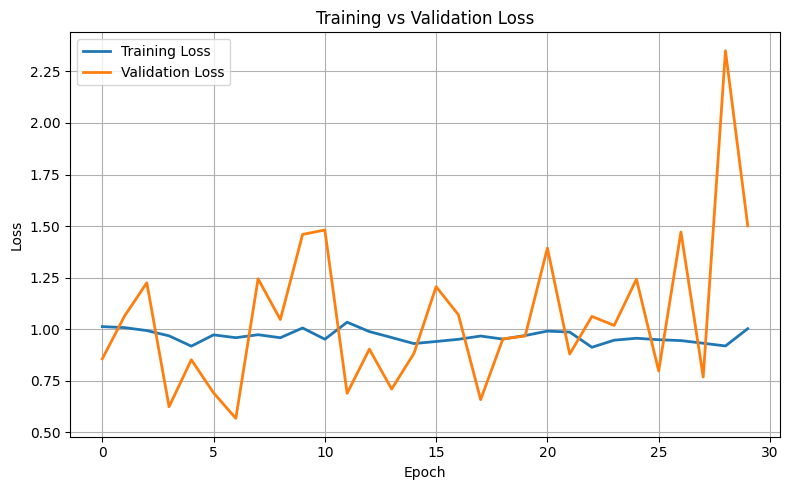

62/62 [==============================] - 0s 4ms/step

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       395
     Class 1       1.00      0.01      0.02       540
     Class 2       0.89      0.70      0.78       772
     Class 3       0.19      0.93      0.31       273

    accuracy                           0.41      1980
   macro avg       0.52      0.41      0.28      1980
weighted avg       0.64      0.41      0.35      1980



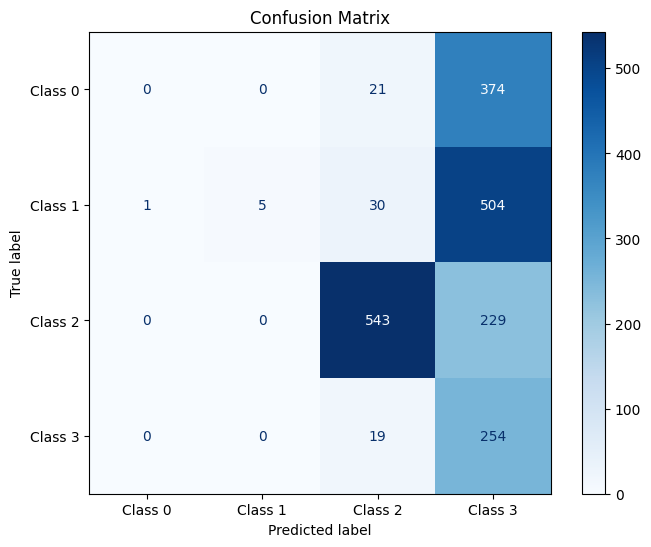

Precision: 0.6438
Recall: 0.4051
F1-Score: 0.3536
ROC-AUC Score: 0.8270


In [143]:


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score

# Train the Model
history2 = baseline_model_task2.fit(
    X_train_task2, 
    y_train_task2,
    epochs=30,
    batch_size=32,
    validation_split=0.2  # 20% of train set used for validation
)

# Plot Training vs Validation Loss
def plot_loss(history2):
    plt.figure(figsize=(8,5))
    plt.plot(history2.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history2.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_loss(history2)

# Get Predictions
y_pred_probs = baseline_model_task2.predict(X_test_task2)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_test_labels = np.argmax(y_test_task2, axis=1)  # Convert one-hot to class labels

# Classification Report
target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix')
plt.show()

# Separate Precision, Recall, and F1-Score
precision = precision_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
f1 = f1_score(y_test_labels, y_pred, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# ROC-AUC Score
roc_auc = roc_auc_score(y_test_task2, y_pred_probs, multi_class='ovr')
print(f"ROC-AUC Score: {roc_auc:.4f}")




## Devised Model for Task 2

In [155]:


from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.losses import CategoricalCrossentropy

improved_cnn_task2 = models.Sequential()

# Conv Block 1
improved_cnn_task2.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.01),strides=(1,1), input_shape=(27,27,3)))
improved_cnn_task2.add(layers.BatchNormalization())
improved_cnn_task2.add(layers.Activation('relu'))
improved_cnn_task2.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Conv Block 2
improved_cnn_task2.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.01)))
improved_cnn_task2.add(layers.BatchNormalization())
improved_cnn_task2.add(layers.Activation('relu'))
improved_cnn_task2.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Conv Block 3
improved_cnn_task2.add(layers.Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.01)))
improved_cnn_task2.add(layers.BatchNormalization())
improved_cnn_task2.add(layers.Activation('relu'))
# improved_cnn_task2.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Global Average Pooling
improved_cnn_task2.add(layers.GlobalAveragePooling2D())

# Fully Connected Layers
improved_cnn_task2.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.01)))
improved_cnn_task2.add(layers.BatchNormalization())
improved_cnn_task2.add(layers.Activation('relu'))
improved_cnn_task2.add(layers.Dropout(0.4))

# Output Layer
improved_cnn_task2.add(layers.Dense(4, activation='softmax'))

# Compile the model
# optimizer = optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)


# loss_fn = CategoricalCrossentropy(label_smoothing=0.1)

optimizer = Adam(learning_rate=0.0001)
improved_cnn_task2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

improved_cnn_task2.summary()






Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_83 (Conv2D)          (None, 25, 25, 32)        896       
                                                                 
 batch_normalization_51 (Bat  (None, 25, 25, 32)       128       
 chNormalization)                                                
                                                                 
 activation_119 (Activation)  (None, 25, 25, 32)       0         
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_84 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 batch_normalization_52 (Bat  (None, 10, 10, 64)     

In [51]:
# from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import regularizers

# def resnet_block(x, filters, kernel_size=3):
#     shortcut = x

#     # First conv
#     x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     # Second conv
#     x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
#     x = BatchNormalization()(x)

#     # 🔧 Projection shortcut (only if needed)
#     if shortcut.shape[-1] != filters:
#         shortcut = Conv2D(filters, (1, 1), padding='same', kernel_regularizer=regularizers.l2(0.001))(shortcut)
#         shortcut = BatchNormalization()(shortcut)

#     # Add skip connection
#     x = Add()([x, shortcut])
#     x = Activation('relu')(x)
#     return x

# # Input layer
# input_layer = Input(shape=(27, 27, 3))

# # Initial conv
# x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001))(input_layer)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)

# x = MaxPooling2D(pool_size=(2, 2))(x)

# # Residual block 1
# x = resnet_block(x, 32)
# x = MaxPooling2D(pool_size=(2, 2))(x)

# # Residual block 2
# x = resnet_block(x, 64)

# # Flatten and dense head
# x = Flatten()(x)
# x = Dense(128, kernel_regularizer=regularizers.l2(0.001))(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(0.5)(x)

# # Output layer: 4 cell types
# output_layer = Dense(4, activation='softmax')(x)

# # Model
# resnet_model = Model(inputs=input_layer, outputs=output_layer)

# # Compile
# optimizer = Adam(learning_rate=0.0001)
# resnet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# # Summary
# resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 27, 27, 3)]  0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 27, 27, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 27, 27, 32)  128         ['conv2d_10[0][0]']              
 alization)                                                                                       
                                                                                                  
 activation_18 (Activation)     (None, 27, 27, 32)   0           ['batch_normalization[0][0]']

In [65]:

# early stopping and model checkpointing

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,  # number of epochs to wait before stopping
    restore_best_weights=True,
    verbose=1
)

# Model checkpoint to save the best model based on val_loss
model_checkpoint = ModelCheckpoint(
    filepath='best_model_task2.h5',  # you can name this whatever you like
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


In [80]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augment_gen = ImageDataGenerator(
    rotation_range=10,        # Smaller rotation
    width_shift_range=0.05,   # Small horizontal shift
    height_shift_range=0.05,  # Small vertical shift
    brightness_range=[0.9, 1.1],  # Slight brightness variation
    zoom_range=0.1,           # Small zoom
    horizontal_flip=True,     # Only if it's biologically plausible
    vertical_flip=False       # Avoid vertical flip for cell images
)


# Validation data — only rescaling
val_gen = ImageDataGenerator(rescale=1./255)

# Create generators from array data
train_generator = augment_gen.flow(X_train_task2, y_train_task2, batch_size=32)
val_generator = val_gen.flow(X_test_task2, y_test_task2, batch_size=32)

In [107]:
# from tensorflow.keras.callbacks import ReduceLROnPlateau

# lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


from tensorflow.keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.9

lr_callback = LearningRateScheduler(lr_scheduler)



Epoch 1/100
197/198 [============================>.] - ETA: 0s - loss: 3.9381 - accuracy: 0.6028
Epoch 1: val_loss did not improve from 0.24920
198/198 [==============================] - 8s 29ms/step - loss: 3.9379 - accuracy: 0.6027 - val_loss: 4.3457 - val_accuracy: 0.4470 - lr: 1.0000e-04
Epoch 2/100
198/198 [==============================] - ETA: 0s - loss: 3.5530 - accuracy: 0.6971
Epoch 2: val_loss did not improve from 0.24920
198/198 [==============================] - 5s 26ms/step - loss: 3.5530 - accuracy: 0.6971 - val_loss: 4.1559 - val_accuracy: 0.5051 - lr: 1.0000e-04
Epoch 3/100
197/198 [============================>.] - ETA: 0s - loss: 3.3283 - accuracy: 0.7235
Epoch 3: val_loss did not improve from 0.24920
198/198 [==============================] - 5s 23ms/step - loss: 3.3269 - accuracy: 0.7238 - val_loss: 3.5211 - val_accuracy: 0.6045 - lr: 1.0000e-04
Epoch 4/100
196/198 [============================>.] - ETA: 0s - loss: 3.1073 - accuracy: 0.7408
Epoch 4: val_loss did no

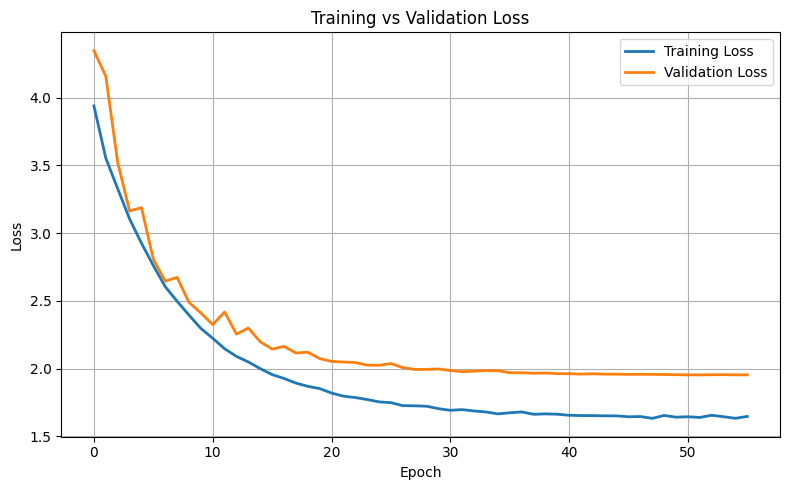

62/62 [==============================] - 1s 7ms/step

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.71      0.72      0.71       395
     Class 1       0.75      0.77      0.76       540
     Class 2       0.87      0.90      0.88       772
     Class 3       0.60      0.51      0.55       273

    accuracy                           0.77      1980
   macro avg       0.73      0.72      0.73      1980
weighted avg       0.77      0.77      0.77      1980



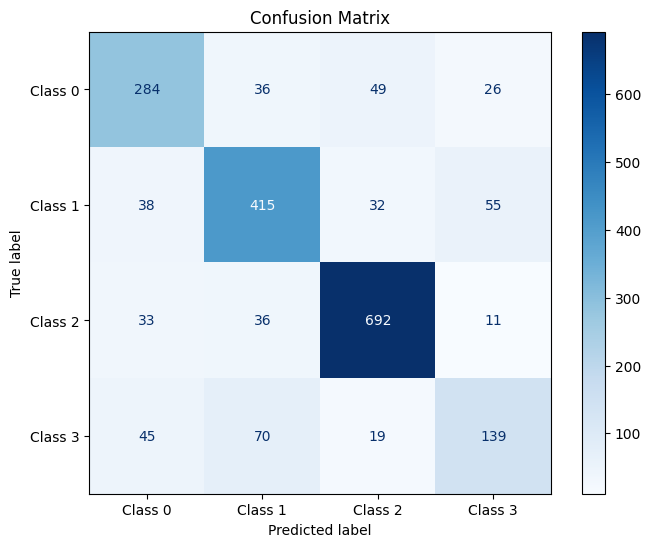

Precision: 0.7685
Recall: 0.7727
F1-Score: 0.7700
ROC-AUC Score: 0.9282


In [156]:

# Without augmentation

## ResNet Model Training

# history = resnet_model.fit(
#     X_train_task2,
#     y_train_task2,
#     epochs=100,
#     batch_size=32,
#     validation_data=(X_test_task2, y_test_task2),
#     callbacks=[early_stop, model_checkpoint]  # Add reduce_lr or live_plot if needed
# )

## CNN Model Training

history_improved_2 = improved_cnn_task2.fit(
    X_train_task2,
    y_train_task2,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_task2, y_test_task2),
    callbacks=[early_stop, model_checkpoint,lr_callback]  # Add reduce_lr or live_plot if needed
)



# with Augmentation

#CNN
# history = improved_cnn_task2.fit(
#     train_generator,
#     epochs=100,
#     validation_data=val_generator,
#     steps_per_epoch=len(X_train_task2) // 32,
#     validation_steps=len(X_test_task2) // 32,
#     callbacks=[early_stop, model_checkpoint]  # Optional: add EarlyStopping, etc.
# )

# ResNet
# history = resnet_model.fit(
#     train_generator,
#     epochs=100,
#     validation_data=val_generator,
#     steps_per_epoch=len(X_train_task2) // 32,
#     validation_steps=len(X_test_task2) // 32,
#     callbacks=[early_stop, model_checkpoint]  # Optional: add EarlyStopping, etc.
# )


# Plot Training vs Validation Loss
def plot_loss(history_improved_2):
    plt.figure(figsize=(8,5))
    plt.plot(history_improved_2.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history_improved_2.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Attempt to plot assuming history variable is available in user's environment
try:
    plot_loss(history_improved_2)
except Exception as e:
    str(e)

# Get Predictions
y_pred_probs = improved_cnn_task2.predict(X_test_task2)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_test_labels = np.argmax(y_test_task2, axis=1)  # Convert one-hot to class labels

# Classification Report
target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix')
plt.show()

# Separate Precision, Recall, and F1-Score
precision = precision_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
f1 = f1_score(y_test_labels, y_pred, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# ROC-AUC Score
roc_auc = roc_auc_score(y_test_task2, y_pred_probs, multi_class='ovr')
print(f"ROC-AUC Score: {roc_auc:.4f}")



## Semi Supervised Learning 

In [157]:
# Load the trained model

from tensorflow.keras.models import load_model

#Load the trained model for task 2 (CellType)

semi_supervised_model_task2 = load_model('best_model_task2.h5')

In [158]:

#navigating to folder containing colon cell histopathology images
image_folder = 'Image_classification_data\patch_images'
images = os.listdir(image_folder)
print(f"Total Numer of Images: {len(images)}")




# Function to load images from the extra dataset
def load_images_extra(image_folder, image_list):
    """Returns a dictionary mapping image names to PIL image objects."""
    images = {}
    for img_name in image_list:
        # Add .png extension if not present
        if not img_name.endswith(".png"):
            img_name += ".png"
            
        img_path = os.path.join(image_folder, img_name)
        try:
            with Image.open(img_path) as img:
                images[img_name] = img.copy()  # Copy to keep it after closing
        except Exception as e:
            print(f"Error loading {img_name}: {e}")
    return images

# Loading the images for the extra dataset
image_objects_extra = load_images_extra(image_folder, labels_extra['ImageName'])

# Adding a new column 'Image' to labels_extra
labels_extra['Image'] = labels_extra['ImageName'].map(image_objects_extra)

# Display the first few rows to confirm
labels_extra.head()


Total Numer of Images: 20280


,InstanceID,patientID,ImageName,isCancerous,Image
0,12681,61,12681.png,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
1,12682,61,12682.png,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
2,12683,61,12683.png,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
3,12684,61,12684.png,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
4,12685,61,12685.png,0,<PIL.Image.Image image mode=RGB size=27x27 at ...


In [159]:
# Convert the images to numpy arrays
import numpy as np

# Convert to NumPy arrays
X_unlabeled = np.array([np.array(img.resize((27, 27))) / 255.0 for img in labels_extra['Image']])

print(f"Unlabeled data shape: {X_unlabeled.shape}")



Unlabeled data shape: (10384, 27, 27, 3)


In [160]:
# Generate pseudo-labels
pseudo_labels = semi_supervised_model_task2.predict(X_unlabeled)

# Convert to one-hot encoded format
pseudo_labels_encoded = np.argmax(pseudo_labels, axis=1)

print(f"Total pseudo-labeled samples: {len(pseudo_labels_encoded)}")


325/325 [==============================] - 3s 8ms/step
Total pseudo-labeled samples: 10384


In [161]:
# Set a confidence threshold
confidence_threshold = 0.9

# Get high-confidence samples
high_confidence_indices = np.max(pseudo_labels, axis=1) > confidence_threshold

X_pseudo = X_unlabeled[high_confidence_indices]
y_pseudo = pseudo_labels_encoded[high_confidence_indices]

print(f"High-confidence pseudo-labeled samples: {X_pseudo.shape[0]}")


High-confidence pseudo-labeled samples: 5458


In [162]:
from tensorflow.keras.utils import to_categorical

# Combine the data
X_combined = np.concatenate((X_train_task2, X_pseudo), axis=0)
y_combined = np.concatenate((y_train_task2, to_categorical(y_pseudo, num_classes=4)), axis=0)

print(f"Combined Training Set - X: {X_combined.shape}, y: {y_combined.shape}")


Combined Training Set - X: (11790, 27, 27, 3), y: (11790, 4)


Epoch 1/10
369/369 [==============================] - 9s 17ms/step - loss: 0.2573 - accuracy: 0.9114 - val_loss: 0.6655 - val_accuracy: 0.7582
Epoch 2/10
369/369 [==============================] - 6s 16ms/step - loss: 0.2519 - accuracy: 0.9148 - val_loss: 0.6420 - val_accuracy: 0.7582
Epoch 3/10
369/369 [==============================] - 6s 15ms/step - loss: 0.2356 - accuracy: 0.9216 - val_loss: 0.6610 - val_accuracy: 0.7689
Epoch 4/10
369/369 [==============================] - 6s 15ms/step - loss: 0.2135 - accuracy: 0.9275 - val_loss: 0.6709 - val_accuracy: 0.7759
Epoch 5/10
369/369 [==============================] - 6s 15ms/step - loss: 0.2059 - accuracy: 0.9295 - val_loss: 0.7300 - val_accuracy: 0.7456
Epoch 6/10
369/369 [==============================] - 6s 16ms/step - loss: 0.1848 - accuracy: 0.9375 - val_loss: 0.6760 - val_accuracy: 0.7614
Epoch 7/10
369/369 [==============================] - 6s 15ms/step - loss: 0.1727 - accuracy: 0.9432 - val_loss: 0.7055 - val_accuracy: 0.7500

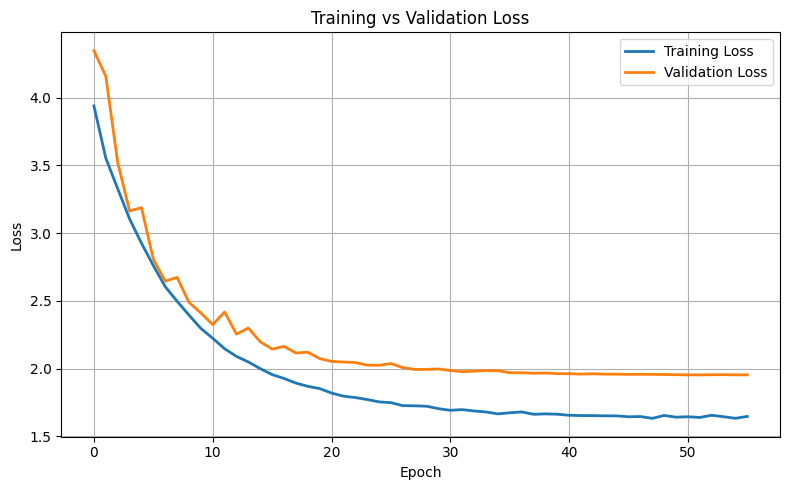

62/62 [==============================] - 1s 8ms/step

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.64      0.61      0.62       395
     Class 1       0.61      0.89      0.72       540
     Class 2       0.95      0.70      0.81       772
     Class 3       0.51      0.48      0.49       273

    accuracy                           0.70      1980
   macro avg       0.68      0.67      0.66      1980
weighted avg       0.74      0.70      0.70      1980



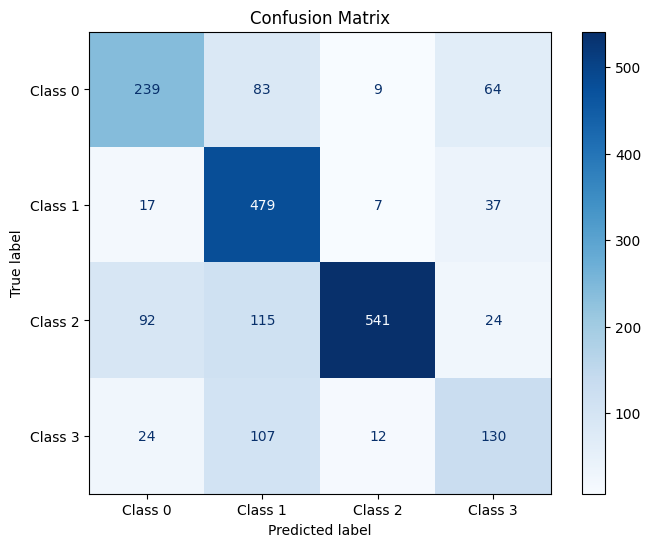

Precision: 0.7358
Recall: 0.7015
F1-Score: 0.7042
ROC-AUC Score: 0.8958


In [163]:
# Fine-tune the model
semi_history = semi_supervised_model_task2.fit(
    X_combined, y_combined,
    validation_data=(X_val_task2, y_val_task2),
    epochs=10,
    verbose=1
)


# Plot Training vs Validation Loss
def plot_loss(semi_history):
    plt.figure(figsize=(8,5))
    plt.plot(semi_history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(semi_history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Attempt to plot assuming history variable is available in user's environment
try:
    plot_loss(history_improved_2)
except Exception as e:
    str(e)

# Get Predictions
y_pred_probs = semi_supervised_model_task2.predict(X_test_task2)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_test_labels = np.argmax(y_test_task2, axis=1)  # Convert one-hot to class labels

# Classification Report
target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix')
plt.show()

# Separate Precision, Recall, and F1-Score
precision = precision_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
f1 = f1_score(y_test_labels, y_pred, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# ROC-AUC Score
roc_auc = roc_auc_score(y_test_task2, y_pred_probs, multi_class='ovr')
print(f"ROC-AUC Score: {roc_auc:.4f}")







# Save the fine-tuned model
semi_supervised_model_task2.save("fine_tuned_cellType_model.h5")
